In [1]:
import sys
sys.path.insert(1, 'C://Users//arthu//git//eyenes')
from eyenes.generation import Generation
import pickle
import numpy as np

Using TensorFlow backend.


In [2]:
dicto = {'size': 20, 'max_steps': 3000, 'freq': .2, 'buffer': 3,
        'layer_prob': .2, 'intensity': 1, 'fps': 4, 'patience': 3,
        'num_survivors': 4, 'similar_penalty': .9, 'mode': 'sequential'}

In [3]:
def save_all(generation):
    pickle.dump(generation.history, open('pickled_model/history.pkl','wb'))
    for i, agent in enumerate(generation.agents):
        pickle.dump(agent.model.model.get_weights(), open('pickled_model/weight_' + str(i) + '.pkl', 'wb'))
        pickle.dump(agent.lineage, open('pickled_model/lineage_' + str(i) + '.pkl', 'wb'))
        
def load_all(generation):
    current_id = 0
    for agent in generation.agents:
        for lineage_id in agent.lineage:
            if lineage_id > current_id:
                current_id = lineage_id
    generation.new_ID = current_id
    generation.history = pickle.load(open('pickled_model/history.pkl','rb'))
    for i, agent in enumerate(generation.agents):
        agent.model.model.set_weights(pickle.load(open('pickled_model/weight_' + str(i) + '.pkl', 'rb')))
        agent.lineage = pickle.load(open('pickled_model/lineage_' + str(i) + '.pkl', 'rb'))

In [4]:
generation = Generation(**dicto)
#load_all(generation)

In [5]:
generation.agents[0].model.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (1, 240, 256, 9)          0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (1, 256, 256, 9)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (1, 64, 64, 9)            0         
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 32, 32, 18)           2610      
_________________________________________________________________
conv2d_2 (Conv2D)            (1, 16, 16, 36)           10404     
_________________________________________________________________
conv2d_3 (Conv2D)            (1, 8, 8, 72)             41544     
_________________________________________________________________
conv2d_4 (Conv2D)            (1, 4, 4, 144)           

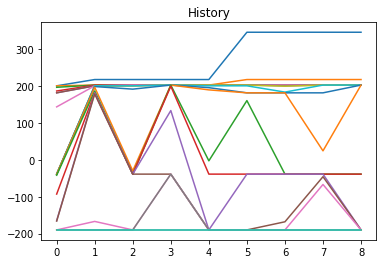

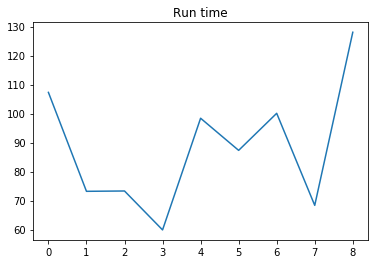

In [ ]:
for i in range(1000):
    generation.evolution_step(plot = True)
    save_all(generation)

In [ ]:
def safe_reward(agent):
    if agent.total_reward is not None:
        return agent.total_reward
    else:
        return -1
    
rewards = [safe_reward(agent) for agent in generation.agents if agent.total_reward]
generation.agents[np.argmax(rewards)].max_steps = 999999
generation.agents[np.argmax(rewards)].run(mode = 'render')